# Projet préparez des données pour un organisme de santé publique

Our goal is to select the best products for a given type of products and given features.
We will ask the user the parameters and give him a ranking of the products as well as a preview of the product (not always available).

But before any ranking, we need to acquire the data and clean them.
We will use the [OpenFoodFacts database](https://world.openfoodfacts.org/data) which is a open database under the Open Database License (ODbL).

In [62]:
# %%capture
# No output

# To run the notebook
# %pip install jupyter

# To draw plots
# %pip install matplotlib
import matplotlib.pyplot as plt
# To draw plots in the notebook
# %matplotlib inline

# To manipulate dataFrames
# %pip install pandas
import pandas as pd

# To use quick functions (mainly on arrays)
# %pip install numpy
import numpy as np

# To plot prettiers graphs simpler
# %pip install seaborn
import seaborn as sns
sns.set()


# Allow to omit the warnings
# %pip install warnings
import warnings
warnings.filterwarnings(action='ignore')

# To print dataframes in a nice way
# %pip install dataframe_image
import dataframe_image as dfi

# To be able to encode dataframe to display them as pictures
# %pip install unicodedata
import unicodedata

# To use widgets to interact with the notebook
# %pip install ipywidgets
import ipywidgets as widgets

from IPython.display import HTML

In [63]:
def export_df(df, name, cols = 20, rows = 20):
    df = df[:cols][:rows]
    df = df.applymap(lambda x : unicodedata.normalize('NFKD', str(x)).encode('ascii', 'ignore').decode())
    dfi.export(df, name, max_cols=cols, max_rows=rows)

In [64]:
url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'

# Download file from url
import urllib.request
urllib.request.urlretrieve(url, 'fr.openfoodfacts.org.products.csv.zip')


# Unzip file
import zipfile
with zipfile.ZipFile('fr.openfoodfacts.org.products.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

data = pd.read_csv('./fr.openfoodfacts.org.products.csv', sep='\t')

URLError: <urlopen error [Errno 2] No such file or directory>

In [36]:
# Deep copy of the original dataframe
df = data.copy()

After downloading and loading the data, let's see the shape of the data. First, we want to have a quick overview of the number of columns and rows and get some statistics about them.

In [37]:
# Quick description of the data
print(f'The dataset contains {df.shape[1]} rows and {df.shape[0]} columns')

The dataset contains 162 rows and 320772 columns


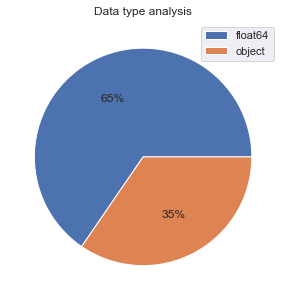

In [38]:
value_counts = df.dtypes.value_counts()
figure, ax = plt.subplots()
figure.set_size_inches(5,5)
plt.pie(value_counts.values, autopct='%1.0f%%')
plt.legend(labels = value_counts.index, loc = "best")
ax.set_title('Data type analysis')
plt.show()

In [39]:
print('Now, let\'s get a quick pic of the data (only the first 5 rows)')
export_df(df.head(), 'data_head.png')

Now, let's get a quick pic of the data (only the first 5 rows)


![DatasetPreview1](data_head.png)

There seems to be a lot of missing values. But before making any cleaning of the data, we must see which are the proportion of missing values and what are the columns we can rely on.

## Missing values analysis

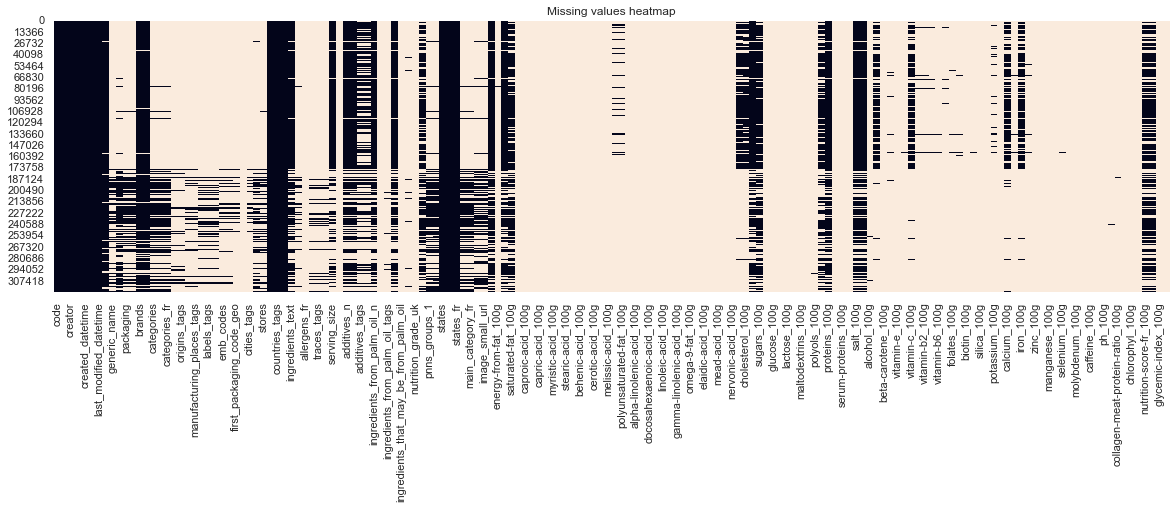

In [40]:
# For better understanding of the dataset completion, we try to display the arrangement of the missing values by using a heatmap

# Very heavy to compute
sns.set()
figure, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(df.isna(), cbar=False, ax = ax)
ax.set_title('Missing values heatmap')
plt.show()

This heatmap is a great way to represent missing values. White parts indicates missing values.

We can instantly see which columns are filled and which are not, for example, `code`, `creator name` and `created_datetime` are columns we can always count on but sadly they aren't very interesting for our analysis.

Hopefully, we can see that a LOT of columns are named `[type]_100g` which means wheight over 100g of product could be a great mesure for our features ! However, a lot of them have are greatly hollow and we won't be able to use them.

Even if this graph is convenient for our eyes, lets put a **totally arbitrary** threshold of missing value to see which columns we will allow us to use !

In [41]:
# After the visualization, we try to mesure the missing values
proportion = 100- (round(df.isna().sum()*100/df.shape[0],2)).sort_values(ascending=True)
print('Columns sorted by their completion rate (only the 10 first and 10 last):')
print(proportion[:10])
print('----------------')
print(proportion[-10:])

Columns sorted by their completion rate (only the 10 first and 10 last):
creator                   100.00
created_t                 100.00
created_datetime          100.00
last_modified_t           100.00
last_modified_datetime    100.00
code                       99.99
url                        99.99
states                     99.99
states_tags                99.99
states_fr                  99.99
dtype: float64
----------------
oleic-acid_100g        0.0
elaidic-acid_100g      0.0
gondoic-acid_100g      0.0
mead-acid_100g         0.0
erucic-acid_100g       0.0
nervonic-acid_100g     0.0
maltose_100g           0.0
maltodextrins_100g     0.0
nucleotides_100g       0.0
water-hardness_100g    0.0
dtype: float64


In [1]:
threshold = 70 # Arbitrairy threshold to determine if a column is usable
print(f'We choose to keep the columns with more than {threshold}% of filled values, which are {len(proportion[proportion > threshold])} columns :')
print(proportion[proportion > threshold].index.to_list())

NameError: name 'proportion' is not defined

Finally, we chose to focus on columns that represent weight per 100g as they seem to have a great completion rate and seem relevant and consitent enough for our analysis.

Now, let's enter the cleaning phase. This is a required step, because if each product are false or missing, we won't be able to evaluate them and rank them as the user would like.

# Data cleaning

First, we must remove the duplicates.
A duplicate is when an identifier column (which is supposed to has only unique values) contains two similar values. This is the case for the `code` column, so we chose to use the `url` column instead.

## Duplicates

In [43]:
df_nan_code = pd.isna(df['code'])
df_nan_url = pd.isna(df['url'])
df_code_possible = df[df_nan_code != df_nan_url]

print(f"There are {df_code_possible.shape[0]} rows where we can compute either the code or url columns.")

# The purpose of this tool is to redirect the user to the openfoodfacts website, if the url is missing and we cannot reconstruct it from the code, we choose to remove the row.
df = df.drop(df[df_nan_code].index)

# Ultimately, even if the code columns contains duplicates, as we choose to use the url column as Id, this is not useful anymore to clean the code column.
df_duplicated_url = df[df['url'].duplicated()].sort_values('url')
print(f"There are {df_duplicated_url.shape[0]} rows where urls are duplicated. We deleted them.")

df = df.drop(df_duplicated_url.index)

There are 0 rows where we can compute either the code or url columns.
There are 0 rows where urls are duplicated. We deleted them.


But unfortunately, duplicates aren't the worst part of data cleaning.
Now, let's head to the incoherent data section.

## Incoherent values

In this chapter, we will focus on selection of incoherent data to remove them from the dataset.
Mainly, we will sum every 'on 100g' columns to see if it sums above 100g. If this is the case, we cannot determine which one (or which one**s**) of the addends is/are the outlier(s) and we must delete the entire row.

Another problem is that, most of the 'on 100g' columns are included in anothers. For exemple, it would be an error to sum 'saturated_fat_100g' and 'fat_100g' as 'saturated_fat_100g' is included in 'fat_100g'.
We must try to understand which columns contains the others.
For this exercice, I needed to do a lot of reasearch on biochemistry and nutrition.

I recommend you to look at the dev notebook to see how I did it, because it was a complex process and I won't go into details here.

In [44]:
# Using our reasearch, this is the dictionnary we came with

dict_feature_combinations = {
    'fat_100g':
              {
              'cholesterol_100g':{},
              'saturated-fat_100g':{
                                    'caprylic-acid_100g':{},
                                    'lauric-acid_100g':{},
                                    'myristic-acid_100g':{},
                                    'palmitic-acid_100g':{},
                                    'stearic-acid_100g':{},
                                    'arachidic-acid_100g':{},
                                    'behenic-acid_100g':{},
                                    'lignoceric-acid_100g':{},
                                    'cerotic-acid_100g':{},
                                    'montanic-acid_100g':{},
                                    'melissic-acid_100g':{},
                                    'butyric-acid_100g':{},
                                    'caproic-acid_100g':{},
                                    'capric-acid_100g':{}
                                  },
              'monounsaturated-fat_100g':{
                                          'omega-9-fat_100g':{
                                                            'oleic-acid_100g':{},
                                                            'elaidic-acid_100g':{},
                                                            'gondoic-acid_100g':{},
                                                            'mead-acid_100g':{},
                                                            'erucic-acid_100g':{},
                                                            'nervonic-acid_100g':{}
                                                            }
                                        },
              'polyunsaturated-fat_100g':{
                                        'omega-3-fat_100g':{
                                                          'alpha-linolenic-acid_100g':{},
                                                          'eicosapentaenoic-acid_100g':{},
                                                          'docosahexaenoic-acid_100g':{}
                                                          },
                                        'omega-6-fat_100g':{
                                                          'linoleic-acid_100g':{},
                                                          'arachidonic-acid_100g':{},
                                                          'gamma-linolenic-acid_100g':{},
                                                          'dihomo-gamma-linolenic-acid_100g':{}
                                                          }
                                        },
              'trans-fat_100g':{}
              },
    'sugars_100g':
                {
                    'carbohydrates_100g':{
                                        'sucrose_100g':{},
                                        'glucose_100g':{},
                                        'fructose_100g':{},
                                        'lactose_100g':{},
                                        'maltose_100g':{}
                    }

                },
    'proteins_100g':{
                    'casein_100g':{},
                    }
    }


# This function can either return every string of a dictionnary of return every columns for every levels (depending of the choosen option)
def multi_purpose_function(dico, option):
  # Option 1: get_every_string_of_dict
  # Option 2: get_levels_features

  parent  =''

  level_list = [set(dico.keys())]
  parent_list = [set()]
  string_list = list(dico.keys())
  # Prends toutes les clefs niveau 1
  keys = list(dico.keys())
  # Tant que la boite à clef à explorer n'est pas vide, on continue à explorer
  while (keys != []):
    # Pour chaque clef de la boite à clefs
    for key in keys:
      # On explore

      # On décompose la clef pour avoir le multi level : On a une clef du type lvl1;lvl2;lvl3...
      sublevel = dico
      string_to_print = ''
      level = 0
      for key_level in key.split(';'):
        string_to_print += '--'
        level += 1
        sublevel = sublevel[key_level]
        if level >= len(level_list):
          level_list.append(set())
        if level >= len(parent_list):
          parent_list.append(set())
        

      # On retourne toutes les clefs (sans les dict([]).keys())
      ajout_list = False
      prochaines_clefs = list(sublevel.keys())
      if len(prochaines_clefs) != 0:
        parent = prochaines_clefs[0] 
      for key2 in prochaines_clefs:
        keys.append(f"{key};{key2}")
        string_list.append(key2)
        level_list[level].add(key2)

        if sublevel[key2] != dict([]):
          level_list[level].add(key2)
        else:
          parent_list[level].add(key2)

      # On retire la clef explorée de la boîte à clef
      keys.remove(key)
  
  for i in range(1,level):
    parent_list[i] = parent_list[i].union(parent_list[i-1])
    level_list[i] = level_list[i].union(parent_list[i-1])


  if option == 1:
    return string_list
  if option == 2:
    level_list.pop()
    return level_list

In [45]:
per_100g_features_list = []

# Get every 'for 100g' column
for index in data.columns:
  if '100' in index and  data[index].dtypes == 'float64': 
    per_100g_features_list.append(index)

# Here we delete the columns that doesn't seem to fit (most of them are just not weights so no possibility to sum them)

not_weight_on_100g_columns = [
                        'energy_100g',
                        'energy-from-fat_100g',
                        'carbon-footprint_100g',
                        'nutrition-score-fr_100g',
                        'nutrition-score-uk_100g', 
                        'glycemic-index_100g',
                        'water-hardness_100g',
                        'ph_100g',
                        'collagen-meat-protein-ratio_100g',
]
for col in not_weight_on_100g_columns :
  per_100g_features_list.remove(col)


# In order not to interfere with the process, every value over 100g is considered as NaN (so will cound as 0 in the sum).
# This is not a problem, as it will be replaced later in the outlier selection process.
for col in per_100g_features_list:
  df.loc[df[col] > 100, [col]] = np.nan

# We select the columns that only are not composed of other columns (the deepest ones)
for feature in multi_purpose_function(dict_feature_combinations,1):
  per_100g_features_list.remove(feature)

# We drop every column that we feel not to fit in the sum for different reasons
col_to_drop = [
          'maltodextrins_100g', # Composed of glucose and fructose. Don't know where to put it.
          'starch_100g', # Disn't find what it is.
          'polyols_100g', # Organic component. Isn't a component of the food.
          'serum-proteins_100g', # Protein coding gene. Don't know where to put it.
          'nucleotides_100g', # Nucleic acid component. Don't know where to put it.
          'beta-carotene_100g', # Precursor of the synthesis of vitamin A. We already study vitamin A.
          'folates_100g', # Same as B9 vitamine
]

for col in col_to_drop:
  per_100g_features_list.remove(col)

# These columns are the deepest ones
per_100g_invar_cols = per_100g_features_list

In [46]:
# Time to do the sums

set_index_surcharge = set()

for i, colonne_list_variable in enumerate(multi_purpose_function(dict_feature_combinations,2)):
  colonne_nom = 'somme_100g_n' + str(i)


  # We sum the deepest one with the level 'columns'
  colonne_list = per_100g_invar_cols + list(colonne_list_variable)

  df[colonne_nom] = df[colonne_list].sum(axis=1)
  set_index_surcharge = set_index_surcharge.union(set(df[(df[colonne_nom] > 100) | (df[colonne_nom] < 0)].index))

# When the weight is over 100g for 100g of product, we don't know what columns are wrong so we must delete the entire row
print('After calculating the sums over 100g of each product, we can delete the outlier rows :')
print(f"We delete {len(set_index_surcharge)} rows on {df.shape[0]} which makes {round(len(set_index_surcharge)*100/df.shape[0],2)}% of the initial dataset.")
print(f"There will be left {df.shape[0]-len(set_index_surcharge)} rows (which is enough to work with).")

df.drop(set_index_surcharge,inplace=True)

After calculating the sums over 100g of each product, we can delete the outlier rows :
We delete 6167 rows on 320749 which makes 1.92% of the initial dataset.
There will be left 314582 rows (which is enough to work with).


After cleaning the duplicates and the incoherent data, let's head to the outliers !

## Outliers

[Outlier definition](https://www.wikiwand.com/en/Outlier): In statistics, an outlier is a data point that differs significantly from other observations.

Outlier selection is a very important but very fastifious step in data cleaning. In other words, there is no need to remove values if we won't use them later.
This is the reason why, in the first step, we will focus on electing the useful columns in order to clean them.

### Interesting features selection

We said earlier that we wanted to focus on columns above the chosen threshold and representing a weight on 100g.

This is why we chose, as arbitrarly as for the threshold, to keep only the following columns :

In [47]:
# We gather the most interesting features (columns) and set options for them that will serve later

filter_features = pd.DataFrame(data=[
           ['fiber_100g',True, 0,50,0,20],
          #  ['cholesterol_100g',False],
           ['trans-fat_100g',False, 0,1,0,1],
           ['calcium_100g',True,0,2,0,2],
           ['iron_100g',True,0,0.2,0,0.04],
          #  ['energy_100g',True],
           ['proteins_100g',True,0,90,0,30],
          #  ['salt_100g',False],
          #  ['sodium_100g',False],
           ['salt_proc_100g',False,0,100,0,20],
           ['vitamins_count',True,0,11,0,11]
          ],
          columns = ['feature', 'shouldIMaximiseIt', 'min_lim', 'max_lim', 'min_lim_arbitrary', 'max_lim_arbitrary'])

print(filter_features['feature'].tolist())


['fiber_100g', 'trans-fat_100g', 'calcium_100g', 'iron_100g', 'proteins_100g', 'salt_proc_100g', 'vitamins_count']


If you have a sharp eye, you'll have notice that we chose the column `vitamins_count`, which is not a weight on 100g, but that is NOT EVEN in the dataset !! You will also notice salt_proc_100g, is also a made up feature.

This is because taking columns from the dataset is great, but we also should create our own variable in order to increase accuracy in our model and give more features to rank the products with.

### Artificial features creation


#### Counting the vitamins


Our first feature isn't that complicated to understand. Instead of leaving the vitamins columns away because they don't have enough data (remember the 70% threshold), we cound missing value as an abscence of vitamin and we sum for each product the number of vitamins.

In [48]:
vitamin_columns = []
for index in data.columns:
  if index[0] == 'v' : vitamin_columns.append(index)

# Also adding new vitamins that aren't labeled as 'vitamins'

# Vitamine B5
vitamin_columns.append('pantothenic-acid_100g')
# Vitamine B8
vitamin_columns.append('biotin_100g')

# Create a new column 'vitamins_count' that will count the number of vitamins in the product
vitamins_bool_isna = pd.notna(df[vitamin_columns])
df['vitamins_count'] = vitamins_bool_isna.sum(axis=1)

The second artificial feature is more of a combination.

In the initial dataset, they were two columns named `salt_100g` and `sodium_100g`. These two columns counts more or less the same thing, the salt proportion, but not the same component.
We can find [here](https://www.wikiwand.com/en/Sodium_chloride) that salt (Sodium Chloride) is composed by 39.34% of sodium and 60.66% of chloride. So `salt = sodium * (100/39.34)`.
In order to be able to use the right column, we chose to create a new column named `salt_proc_100g` which is the same value as the salt column if filled, or the calculation with the sodium in the other case.

In [49]:
salt_columns = ['salt_100g', 'sodium_100g']

# NaN values in the salt rows
rows_where_salt_na = df['salt_100g'].isna()
# but filled value in the sodium row
rows_where_sodium = df['sodium_100g'].notna()

rows_where_must_calculate_salt = df[rows_where_salt_na & rows_where_sodium].index.tolist()

def _fill_salt_proc_100g_column(x):
  # If there is no salt but sodium, we return the operation, in the otehr case, we simply return the salt value
  return x['sodium_100g'] * (100/39.34) if x.name in rows_where_must_calculate_salt else x['salt_100g']

df['salt_proc_100g'] = df.apply(lambda x: _fill_salt_proc_100g_column(x), axis=1)

### Outliers selection in selected features

Now that we have the features we want to use for our ranking, we can start the detection of outliers.
But what outliers means, for each feature ? Is 30g for 100g of fiber an outlier or not ?
Well, if you're not a nutritionist or a biochemist, you'll probably not know and have to search by yourself.

This is why I had to search on the web reliable sources for every low and high limits for each feature (and this is when I realised doing it for only a subset of the features was a great idea).

Fortunately, I found a report of the [FoodData Central Dataset of the US department of Agriculture](https://fdc.nal.usda.gov/fdc-app.html#/) which contains a lot of products and their nutritional information. And this is how I achieve to gather every possible limits for each feature. Later, after the visualisation of the distribution of each feature (you'll see it later, don't worry), I also submitted some more 'arbritary' limits.

In [50]:
export_df(filter_features.drop('shouldIMaximiseIt',axis=1), 'filter_features.png')

![selected_features_and_their_limits](filter_features.png)

In [51]:
df_without_outliers = df.copy()
df_without_outliers_sharp = df.copy()


for index, feature in filter_features.iterrows() :
  feature_name = feature['feature']

  lim_bas_sharp = feature['min_lim_arbitrary']
  lim_haut_sharp = feature['max_lim_arbitrary']
  lim_bas = feature['min_lim']
  lim_haut = feature['max_lim']

  conditions = (df_without_outliers[feature_name] > lim_haut) | (df_without_outliers[feature_name] < lim_bas)
  conditions_sharp = (df_without_outliers_sharp[feature_name] > lim_haut_sharp) | (df_without_outliers_sharp[feature_name] < lim_bas_sharp)

  # Colonnes we will display over the plots
  display_columns = [feature_name,'product_name','brands', 'code']

  df_without_outliers.loc[conditions, feature['feature']] = np.nan
  df_without_outliers_sharp.loc[conditions_sharp, feature['feature']] = np.nan

### Outliers visualization

This is the moment we've been waiting for, we'll able to see the distribution of our data and the removal of our outliers.

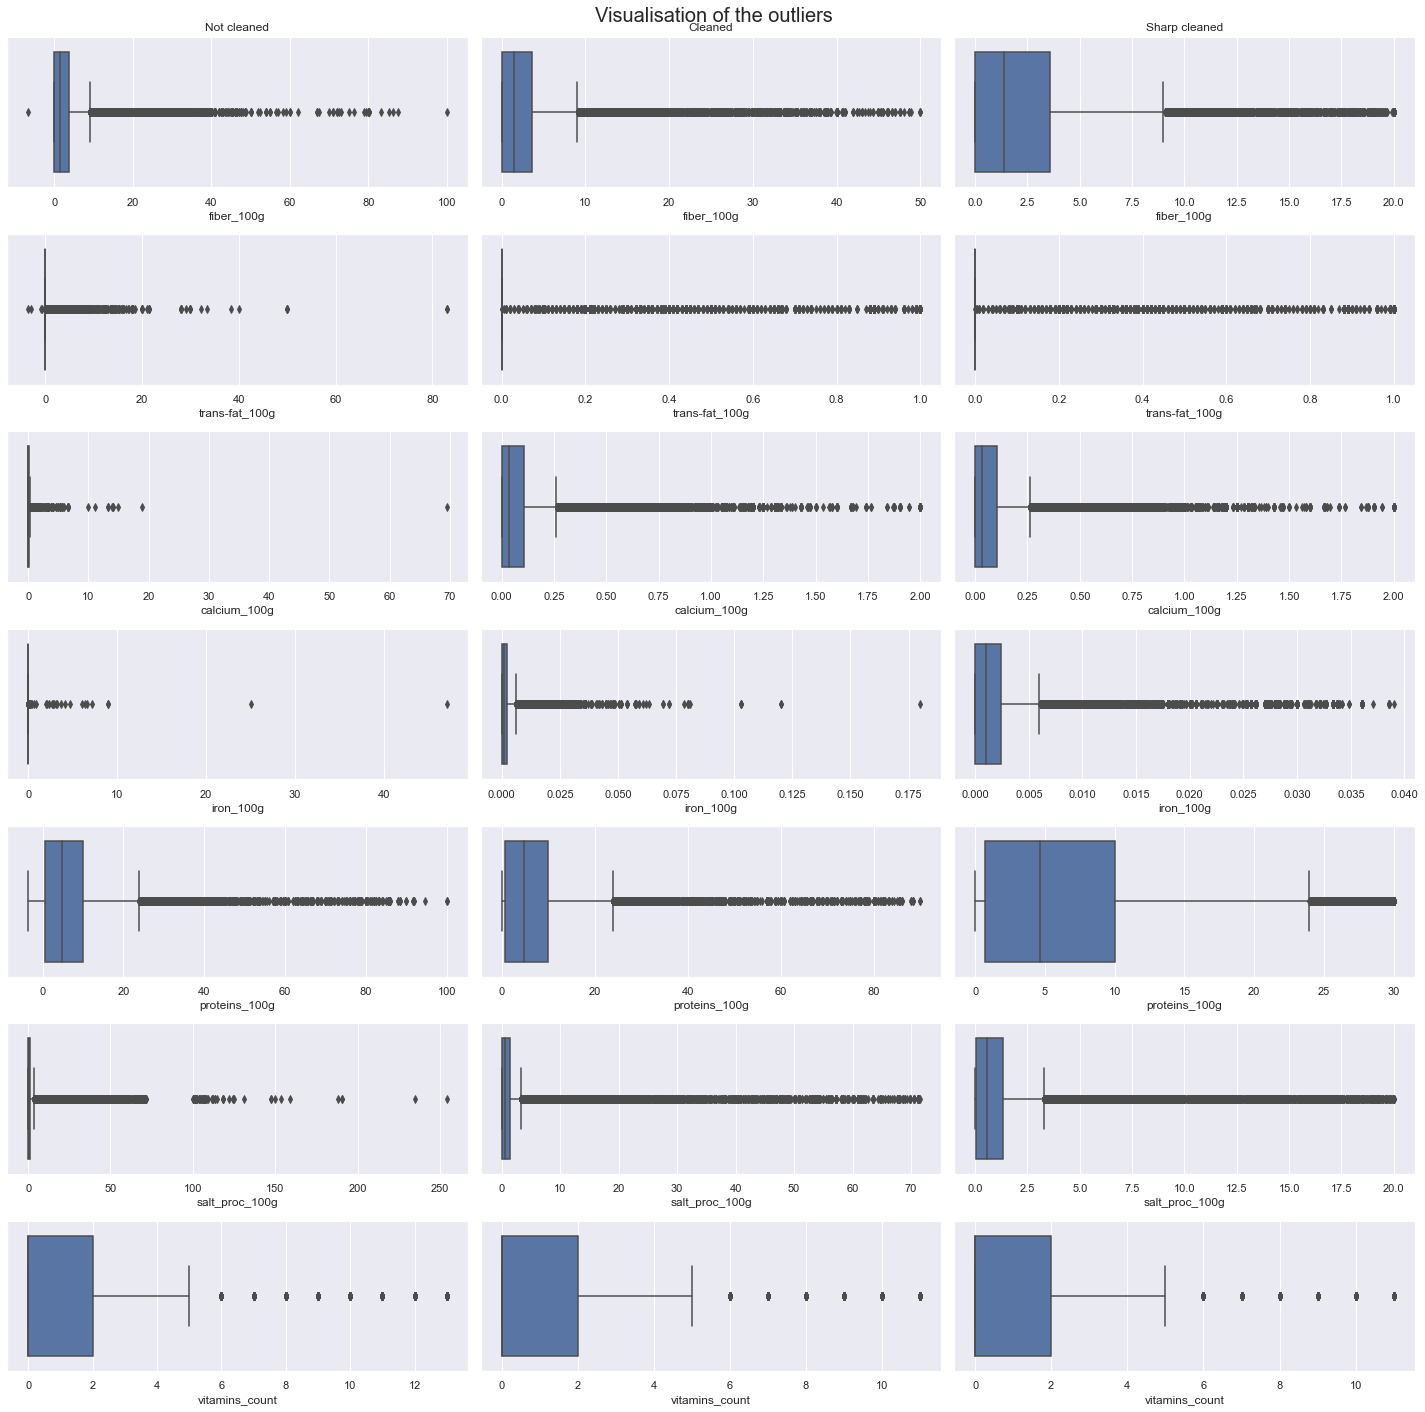

In [52]:
# We will visualize our outliers using boxplots

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(filter_features.shape[0], 3, figsize=(20, 20))
cols = ['Not cleaned', "Cleaned", "Sharply cleaned"]
figure.suptitle('Visualisation of the outliers', fontsize=20)
for ax, col in zip(axis[0], cols):
    ax.set_title(col)
sns.set_theme(style="whitegrid")


for index, column in filter_features.iterrows():
  # Keeping the oultiers
  sns.boxplot(ax=axis[index,0], x=df[column['feature']])

  # Removing the oultiers
  sns.boxplot(ax=axis[index,1], x=df_without_outliers[column['feature']])

  # Removing the oultiers with more fine limits
  sns.boxplot(ax=axis[index,2], x=df_without_outliers_sharp[column['feature']])

figure.tight_layout()
plt.show()

Then, we had to drop the outliers, and chosing the limits. Do we prefer, the fine sharper one, or the one found on the Food Central dataset ?



In [53]:
# Shoud we use sharp cleaning ?
use_sharp_limits = True
print(f"We will use sharp limits ? {'Yes' if use_sharp_limits else 'No'}")

df = df_without_outliers_sharp if use_sharp_limits else df_without_outliers

We will use sharp limits ? Yes


But keep in mind that, unlike the incoherent values (the sums over 100g), here we know which value is the outlier and we can remove the value itself, not deleting the entire row. We just have to replace the outlier by a missing value and keep the other values in the same row.

## Missing values treatment



After removing any duplicates, incoherent values and outliers, we now have to deal with missing values.
Here, identifying them is not a problem because they all have the same value, np.nan.
But the real problem is to replace them by a value that we will predict !

We will use two methods of prediction : 

* The first is the regression method : more accurate but requires more data. The process isn't that hard, just give a lot of non-missing values to a model that will try to guess a linear equation between all the features and later will be  able to predict your taget feature if you give it the same parameters as the training ones.

e.g. : You want your model to give you the perfect proportion of ingredient to bake a cake for a given number of people. You'll give it the recipe for 4 people, 6 people, 8 people, etc... And it'll learn that it is proportionnal and when you'll need to bake for 20 people, it'll give you the perfect proportion of ingredient. But, it won't work if you don't tell it that you want to bake for 20 people. It won't be able to guess.

* In the other hand, the second method, the imputation method, is simpler and won't require any other variable to guess. It'll just take the mean/median/best value of the column and copy it to the missing values. It is not very accurate because it doesn't take in account the other variable of this row, but it won't make a huge difference in the distribution.

e.g. : A student have been missing at an exam and you want to predict his grade. You'll give the grades of the other students and it'll be able to predict his grade by doing the mean of the other grades.

In order to have the most accurate data, we will do imputation only on subset of the dataset filtered by group (another variable).


In priority, we want to use the first method, but as you can see, you need a lot of data because, firstly, the model need to understand the correlated variables (you don't need to know the hour of the day to bake your cake, but the number of people is important) and then it needs to have those data to predict the missing value.
If we don't have those data, we'll use the second model.

In [54]:
def choose_most_related_features(df, target, nb, features, quiet = True):
  if not quiet : print('\nChoose_most_related_features')

  if target in features : features.remove(target)

  features_list = features + [target]

  corr = df[features_list].corr()

  corr = corr.drop(target)
  correlated_features = []
  for i in range(nb):
    feature_label = corr[target].abs().idxmax()
    if not quiet : print(f"-- Feature selected n°{i+1} : {feature_label} with corr {round(corr[target][feature_label],3)*100}%")
    correlated_features.append(feature_label)
    corr = corr.drop(feature_label)
  return correlated_features

In [55]:
from sklearn.impute import SimpleImputer

def make_imputation(df, target, method, quiet = True):
  if not quiet : print('\nImputation')
  df['pnns_groups_2'] = df['pnns_groups_2'].apply(lambda x : 'nan' if pd.isna(x) else x) # Do this because if not, it is impossible select the nan group

  for group2 in df['pnns_groups_2'].unique():
    sub_df = df[df['pnns_groups_2'] == str(group2)][target]
    if not quiet : print(f"------ {group2} --> {sub_df.shape[0]} row and {sub_df.isna().values.sum()} imputations found !")
    sub_df[sub_df.isna()]['target_imputed'] = 1
    imputer = SimpleImputer(missing_values=np.nan, strategy=method)
    imp_ser = imputer.fit_transform(sub_df.values.reshape(-1, 1))
    df.loc[df['pnns_groups_2'] == group2, target] = imp_ser

  return df

In [56]:
from sklearn import linear_model

def make_regression(df, features, target, quiet = True):
  if not quiet : print('\nRegression')
  # We split the dataset into two groups, the one where the target is filled (to train the regression) and the other where the target is missing (to make the prediction).
  columns_used = features + [target]
  train_df = df[columns_used]
  train_df = train_df.dropna()
  
  train_features = train_df[features]
  train_target = train_df[target]


  predict_df = df[df[target].isna()]

  predict_df = predict_df[features].dropna()
  if (predict_df.shape[0] == 0 and not quiet):
    print('-- Not enough valid features to make any prediction. At least one feature in each prediction row is missing. Will do it by imputation.')
  else:
    if not quiet : print(f"-- {predict_df.shape[0]} rows eligible to prediction")
    predict_features = predict_df[features]

    X = train_features
    y = train_target
    regr = linear_model.LinearRegression()
    if not quiet : print('---- fitting...')
    regr.fit(X, y)
    if not quiet : print('---- fitted')
    predict_df[target] = regr.predict(predict_features)
    df.loc[predict_df.index,target] = predict_df
  return df

In [57]:
nb_correlated_features = 5
interesting_features = proportion[proportion > threshold].index.tolist()

print('Doing the process of regression then imputation for each feature but only displaying the first one :')
for index, target in enumerate(filter_features['feature'].tolist()):
  # On rajoute une colonne flag pour si la target a été imputed ou non.
  # Ca sert pour amélriorer la regression.
  # Ce flag est reset pour chaque nouvelle target
  df['target_imputed'] = 0
  
  if index == 0 : print(f"_________________________________________________________________\nFilter n°{index+1} : {target}")

  most_related_features = choose_most_related_features(df, target , nb_correlated_features, interesting_features, quiet = False if index == 0 else True)
  if index == 0 : print(f"\n{df[target].isna().sum()} targets left to predict")

  regression_df = make_regression(df, most_related_features, target, quiet = False if index == 0 else True)
  if index == 0 : print(f"\n{regression_df[target].isna().sum()} targets left to impute")

  imputed_df = make_imputation(regression_df, target, 'mean', quiet = False if index == 0 else True) # Faire une moyenne en prenant la même catégorie de produits

  assert imputed_df[target].isna().sum() == 0, f"imputation failed, there are still missing values in {target}"

  df.loc[:,target] = imputed_df[target]

Doing the process of regression then imputation for each feature but only displaying the first one :
_________________________________________________________________
Filter n°1 : fiber_100g

Choose_most_related_features
-- Feature selected n°1 : carbohydrates_100g with corr 31.1%
-- Feature selected n°2 : proteins_100g with corr 25.4%
-- Feature selected n°3 : fat_100g with corr 20.599999999999998%
-- Feature selected n°4 : additives_n with corr -15.7%
-- Feature selected n°5 : energy_100g with corr 4.6%

119210 targets left to predict

Regression
-- 53648 rows eligible to prediction
---- fitting...
---- fitted

65562 targets left to impute

Imputation
------ nan --> 222023 row and 35102 imputations found !
------ unknown --> 22319 row and 11246 imputations found !
------ Vegetables --> 2827 row and 1027 imputations found !
------ Biscuits and cakes --> 4535 row and 678 imputations found !
------ Bread --> 1838 row and 303 imputations found !
------ Legumes --> 914 row and 206 imputat

Ok ! The cleaning is done ! It has been a long process but now we can look at a cleaned and full dataset and try to make the ranking we wanted.
First, let's take a look at the distribution of the features to see if there is some important behaviour to notice.

# Exploratory analysis of the cleaned dataset

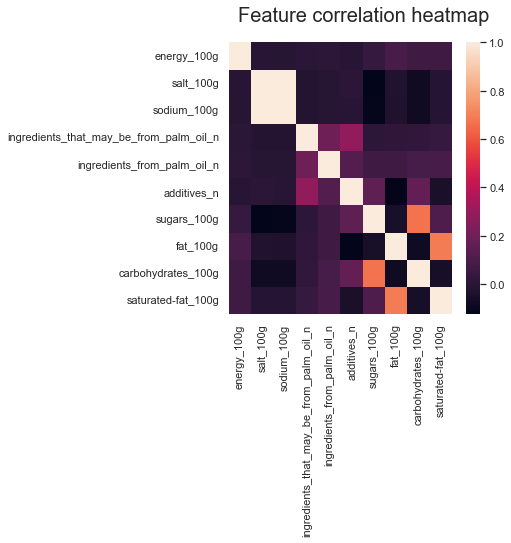

In [58]:
corr = df[interesting_features].corr()


# To show heatmap
fig, axs = plt.subplots(1,1,figsize=(5,5))
fig.suptitle('Feature correlation heatmap', fontsize=20)
sns.heatmap(corr)
plt.show()

An interesting fact is that ingredient_that_may_be_from_palm oil is greatly correlated with additives.
This is not a correlation we exploit later but deserves to be noticed.

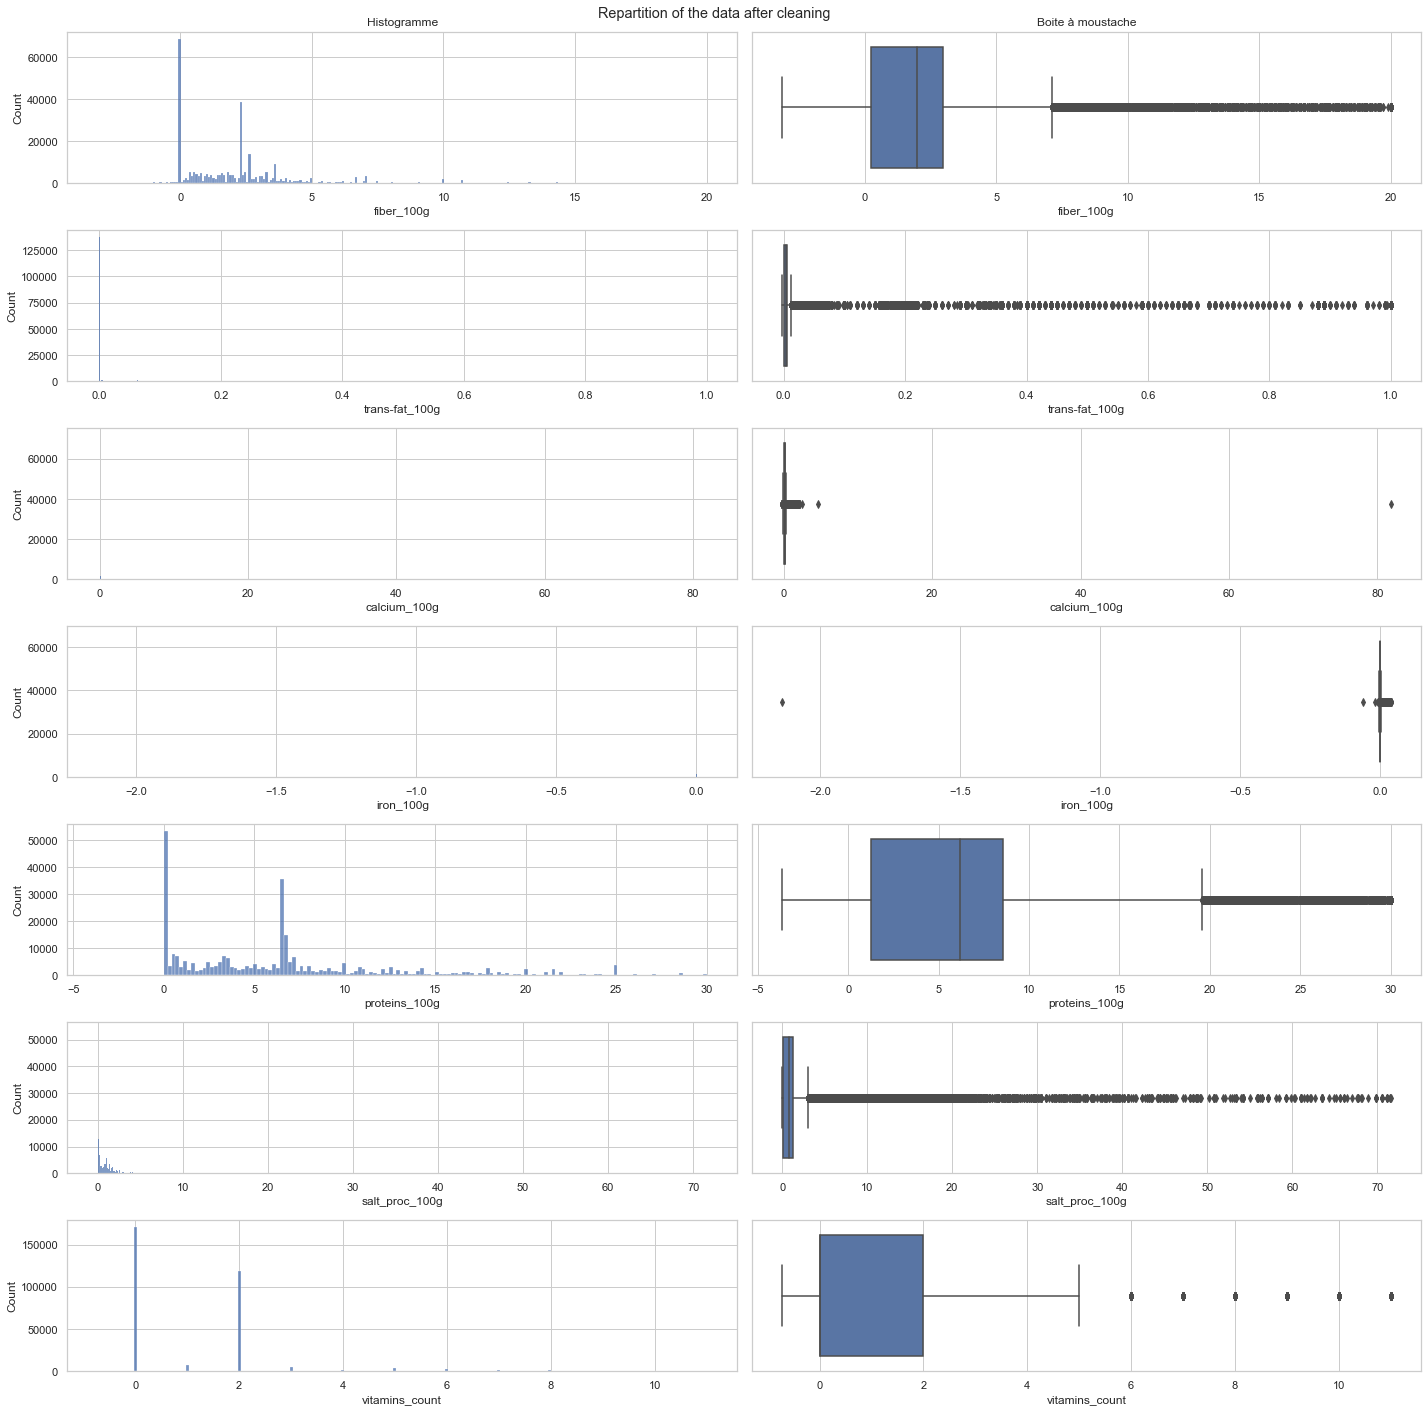

In [59]:
# Analysis of the data repartition on the interesting features columns after cleaning

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(filter_features.shape[0], 2, figsize=(20, 20))
figure.suptitle('Repartition of the data after cleaning')
cols = ['Histogram','Boxplot']
for ax, col in zip(axis[0], cols):
    ax.set_title(col)
sns.set_theme(style="whitegrid")


for index, column in filter_features.iterrows():
  # histograme
  sns.histplot(ax=axis[index,0], x=df[column['feature']])

  # Boxplot
  sns.boxplot(ax=axis[index,1], x=df[column['feature']])

figure.tight_layout()
plt.show()

We can notice that the linear regression created some outliers (eg : negative values of fiber). We know they were added with regression because we cleaned the oultiers before doing any prediction. Or, with cleaned data (over 0g), imputation is not able to predict negative value but linear regression is.

## Principal component analysis

After visualizing the distribution of the features, we'll briefly try to find some 'regrouping features' that will help us to reduce the dimension of our dataset. It is called PCA.

In [60]:
# Functions definition

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

# Taken from here https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire/blob/master/functions.py
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

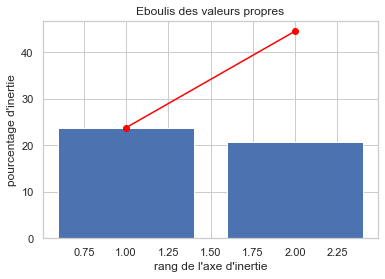

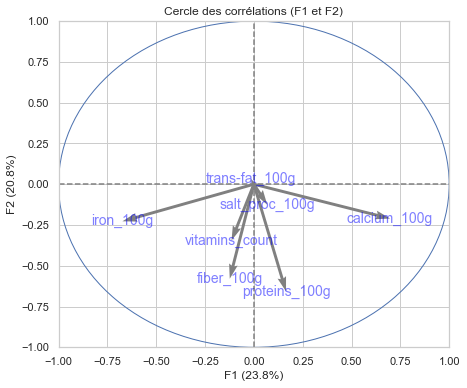

In [61]:
# PCA realisation

from sklearn import decomposition
from sklearn import preprocessing

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

floatInterrestingFeatures = [col for col in df[interesting_features].columns if df[col].dtypes == 'float64'] 
data = df[filter_features['feature']]

# Selection of the number of PCA components
n_comp = 2

# Centering and Reduction
std_scale = preprocessing.StandardScaler().fit(data.values)
X_scaled = std_scale.transform(data.values)


# PCA calculations
pca = decomposition.PCA(n_components=n_comp)


pca.fit(X_scaled)

# Cumulated inertia
display_scree_plot(pca)

# Correlation circles
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(data.columns))

# # Data projection (doesn't work properly)
# X_projected = pca.transform(X_scaled)
# display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(data.index))

# plt.show()

These are not really easy to interpret, so we won't use them.

In the technical notebook, you'll also find ANOVA and fisher's test to test for hypothesis but we won't include them here as they don't serve our main goal (ranking products by feature.)

# Ranking

You've been waiting for too long ! Time to rank them all !

Please read carefully the following instructions to ensure you know how to get what you want.

* Do you want a demo ? Click the Auto button and the computer will choose random parameters.
* Do you wand to tune your own filtering ? Please provide the name of the product you want to rank, the filters you want to rank and the number of products you want to rank and click Manual !

In [ ]:
%%capture

from IPython.display import HTML, display

%pip install ipywidgets
import ipywidgets as widgets

plt.ioff()

In [5]:
class App:
    def __init__(self, df, filter_features):
        self._df = df
        
        self._nb_products_max  = 10
        self._nb_products_min  = 3
        
        self._list_score_col_label = []

        self._filter_features = filter_features

        self._product_list = self._create_product_list()
        self._product_list_size = 0


        self._old_product = []
        self.product = []
        self._product_input = self._create_product_input()

        self._old_filters = []
        self.filters = []
        self._filters_list = self._create_filters_list()
        self._filters_input = self._create_filters_input()

        self._old_nb_products = self._nb_products_min
        self.nb_products = self._nb_products_min
        self._nb_products_input = self._create_nb_products_input()

        self._manual_button = self.create_button_manual()
        self._input_container = widgets.HBox([self._manual_button, self._product_input, self._filters_input, self._nb_products_input])

        self._auto_button = self.create_button_auto()
        
        self._plot_container = widgets.Output()
        
        self.container = widgets.VBox([self._auto_button, self._input_container, self._plot_container],layout=widgets.Layout())

        self._update_app()

    @classmethod
    def create_class(cls, df, filter_features):
        return cls(df, filter_features)
    
    def _create_product_input(self):
        product_input = widgets.Combobox(
                placeholder='Choose a product (in the list or not)',
                options= self._product_list,
                description='Combobox:',
                ensure_option=False,
                disabled=False
            )
        return product_input

    def _create_filters_input(self):
        filters_input = widgets.SelectMultiple(value = [], options = self._filters_list, allow_duplicates = True, description = 'Filters (select multiple)', disabled = False)
        return filters_input
        
    def _create_nb_products_input(self):
        nb_products_input = widgets.IntSlider(value=5, min=self._nb_products_min, max=self._nb_products_max, step=1, description='Number of products to rank', id='test')
        return nb_products_input
    
    def create_button_auto(self):
        button = widgets.Button(description='Auto')
        button.on_click(self._launch_auto)
        return button

    def create_button_manual(self):
        button = widgets.Button(description='Manual')
        button.on_click(self._launch_manual)
        return button
    
    def _create_filters_list(self):
        return self._filter_features['feature'].tolist()

    def _create_product_list(self):
        sub_df_value_counts = self._df['product_name'].value_counts() > 50
        return sub_df_value_counts[sub_df_value_counts.values == True].index.tolist()
    
    def _launch_auto(self, _):
        filtersList = self._filter_features['feature'].tolist()
        self.filters = np.random.choice(filtersList, size=np.random.randint(1,7), replace=False).tolist()
        self._filters_input.value = self.filters

        random_product = np.random.choice(self._product_list, size=1, replace=False)[0]
        self.product = random_product
        self._product_input.value = random_product

        self.nb_products = np.random.randint(self._nb_products_min, self._nb_products_max)
        self._nb_products_input.value = self.nb_products


        self._update_app()

    
    def _launch_manual(self, _):
        self.filters = self._filters_input.value
        self.product = self._product_input.value
        self.nb_products = self._nb_products_input.value

        self._update_app()

    def _ranking(self, df, product_name, filters, nb_products, filter_features):
        selected_df = df
        product_list = selected_df[selected_df['product_name'].str.contains(product_name, case=False, na=False)]

        list_score_col_label = set()
        for index, feature in enumerate(filters):
            should_maximise = self._filter_features.loc[self._filter_features['feature'] == feature,('shouldIMaximiseIt')].iloc[0]
            print(f"feature is {feature} and should I maximise it ? {should_maximise}")
            product_list[feature + '_rank'] = product_list[feature].rank(ascending=should_maximise)
            list_score_col_label.add(feature + '_rank')

        self._list_score_col_label = list_score_col_label
        product_list['sum_scores_rank'] = product_list[list_score_col_label].sum(axis=1)
        product_list['multiple_rank'] = product_list['sum_scores_rank'].rank()
        best = product_list.nlargest(nb_products, 'multiple_rank')
        self._product_list_size = product_list.shape[0]
        return best

    
    def _update_app(self, *args):
        if ((len(args) > 0) and (args[0]['name'] == '_property_lock')):
                match str(args[0]['owner'])[:8]:
                    case 'IntSlide':
                        self.nb_products = args[0]['old']['value']
                    case 'Combobox':
                        self.product = args[0]['old']['value']
                    case 'SelectMu':
                        filtersIndex = args[0]['old']['index']
                        self.filters = []
                        for index in filtersIndex:
                            self.filters.append(self._filters_list[index])

        if (len(self.filters) and (self.product) and (self.nb_products)):
            best = self._ranking(self._df, '' if len(self.product) == 0 else self.product, self.filters, self.nb_products, self._filter_features)

            self._old_filters = self.filters
            self._old_product = self.product
            self._old_nb_products = self.nb_products


            with self._plot_container:
                self._plot_container.clear_output(wait=True)
                plt.figure(figsize=(20,30))


                if len(self._list_score_col_label) > 1:
                    new_perc_cols = set()
                    self._list_score_col_label.add('multiple_rank')

                    # Pour que ce soit plus lisible dans le graphique, on va noter chaque rank en pourcentage (ex : 6ème sur 10 --> (6/10) * 100 = au dessus de 60% de l'échantillon)
                    for feature_rank in self._list_score_col_label:
                        col_name = feature_rank + '_perc'
                        best[col_name] = best[feature_rank]*100/self._product_list_size
                        new_perc_cols.add(col_name)
                    
                else : # Si il n'y a qu'une seule colonne, on préfere afficher la colonne en question plutôt qu'un ranking par rapport aux autres
                    new_perc_cols = self.filters

                # On rajoutera aussi aux brand names le nom du produit
                best['new_name'] = best['brands'] + '\n' + best['product_name']


                # Avec sns
                best_sns = best.melt(id_vars="new_name")

                best_sns = best_sns.drop(best_sns[~best_sns['variable'].isin(new_perc_cols)].index).sort_values('value', ascending=False)

                fig, axs = plt.subplots(1,1,figsize=(len(new_perc_cols)*5,5))
                sns.barplot(x='new_name', y='value', hue='variable', data=best_sns, ax=axs)
                axs.tick_params(axis='x', rotation=90, labelsize=20)
                fig_title = f"Ranking of {self.product} by {self.filters}"
                axs.set_title(fig_title,fontsize=30)
                axs.set_xlabel("Product name",fontsize=20)
                axs.set_ylabel("Ranking (in %)",fontsize=20)
                axs.set_ylim(bottom = 0)
                axs.tick_params()
                plt.show()

In [ ]:
app = App.create_class(df, filter_features)

app.container